In [1]:
%load_ext autoreload
%autoreload 2 

import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
from tensorflow.keras import layers,models,datasets,callbacks
import tensorflow.keras.backend as K

from utils import display


2023-07-10 20:31:56.874772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 20:31:56.946123: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 20:31:56.967809: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-10 20:31:57.322272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1 Physical GPUs, 1 Logical GPUs


2023-07-10 20:31:57.876775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 20:31:57.897643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 20:31:57.897765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 20:31:57.898248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

## Autoencoder

An autoencoder is made of two parts encoder network and a decoder network. The encoder network compresses high diensional input data to low dimensional embedding vector and decoder decompress a given embedding vector back to the original domain.

In [2]:
IMAGE_SIZE = 32 
CHANNELS = 1 
BATCH_SIZE = 100 
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM  =2 
EPOCHS = 3

## Preprare the data 

In [3]:
#load the data 
(x_train, y_train) , (x_test, y_test) = datasets.fashion_mnist.load_data()


In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
#Preprocess the data 
def preprocess(imgs):
    """
        Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0 
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)),constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs 

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
x_train.shape

(60000, 32, 32, 1)

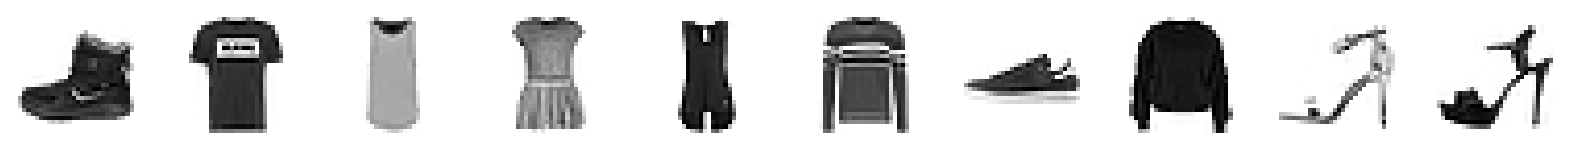

In [7]:
display(x_train)

### Build the autoencoder

In the encoder layer, the image from input layer are passed thorugh three conv2D layer with strides of 2. These layers will be capturing the high level features. After that, the output from the last convolutional layer is flattend and connected to the dense layer representing our latent space.

In [11]:
#Encoder 
encoder_input = layers.Input(shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS),name="encoder_input")
x = layers.Conv2D(32,(3,3),strides=2, activation="relu",padding="same")(encoder_input)
x = layers.Conv2D(64,(3,3), strides=2,activation="relu",padding="same")(x)
x = layers.Conv2D(128,(3,3), strides=2, activation="relu",padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:] #needed for decoder 

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM,name="encoder_output")(x)
encoder = models.Model(encoder_input,encoder_output)
encoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable

## Convolutional Transpose layer in Decoder 
The convolutional transpose layer performs the reverse operation of the convolutional layer where the output image has the higher dimension. The input images are zero padded internally between the pixels and the convolution operation is performed. 

In [13]:
#Decoder 
decoder_input = layers.Input(shape=(EMBEDDING_DIM,),name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128,(3,3), strides=2,activation="relu",padding="same")(x)
x = layers.Conv2DTranspose(64,(3,3),strides=2,activation="relu",padding="same")(x)
x = layers.Conv2DTranspose(32,(3,3),strides=2,activation="relu",padding="same")(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3,3),
    strides =1,
    activation="sigmoid",
    padding="same",
    name="decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 32)       1846

- The output of the autoenvoder is the output from the encoder (embeddings ) that is passed through the decoder network

In [14]:
#Autoencoder 
autoencoder = models.Model(
    encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_2 (Functional)        (None, 32, 32, 1)         2462

### Train the autoencoder 

- In an autoencoder network, losses can be both RMSE and binary cross-entropy 
- In RMSE, an overestimation is penalized equivalently to an understimation, so the generated output will be distributed around pixels
- The binary cross-entropy loss penalizes erroers toward the extremes more heavily than errors toward the center. 
- This effect makes the output from binary cross-entopy more blurrier images than RMSE loss. 

In [15]:
#compile
autoencoder.compile(optimizer="adam",loss="binary_crossentropy")


In [16]:
#create a model save checkpoint 
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="../checkpoint",
    save_weights_only =False,
    save_freq="epoch",
    monitor="loss",
    mode= "min",
    save_best_only=True,
    verbose=0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="../logs")

In [17]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test,x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3


2023-07-10 20:59:21.409927: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-07-10 20:59:22.163672: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


593/600 [============================>.] - ETA: 0s - loss: 0.2991

INFO:tensorflow:Assets written to: ../checkpoint/assets


INFO:tensorflow:Assets written to: ../checkpoint/assets


600/600 [==============================] - 7s 8ms/step - loss: 0.2987 - val_loss: 0.2658
Epoch 2/3
598/600 [============================>.] - ETA: 0s - loss: 0.2606

INFO:tensorflow:Assets written to: ../checkpoint/assets


INFO:tensorflow:Assets written to: ../checkpoint/assets


600/600 [==============================] - 4s 7ms/step - loss: 0.2606 - val_loss: 0.2591
Epoch 3/3
592/600 [============================>.] - ETA: 0s - loss: 0.2559

INFO:tensorflow:Assets written to: ../checkpoint/assets


INFO:tensorflow:Assets written to: ../checkpoint/assets


600/600 [==============================] - 5s 8ms/step - loss: 0.2559 - val_loss: 0.2558


In [18]:
#save the final models
autoencoder.save("../models/autoencoder")
encoder.save("../models/encoder")
decoder.save("../models/decoder")

INFO:tensorflow:Assets written to: ../models/autoencoder/assets


INFO:tensorflow:Assets written to: ../models/autoencoder/assets


INFO:tensorflow:Assets written to: ../models/encoder/assets


INFO:tensorflow:Assets written to: ../models/encoder/assets


INFO:tensorflow:Assets written to: ../models/decoder/assets


INFO:tensorflow:Assets written to: ../models/decoder/assets


### Reconstruct using the autoencoder

In [19]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
examples_labels = y_test[:n_to_predict]

157/157 [==============================] - 0s 1ms/step
Example real clothing items


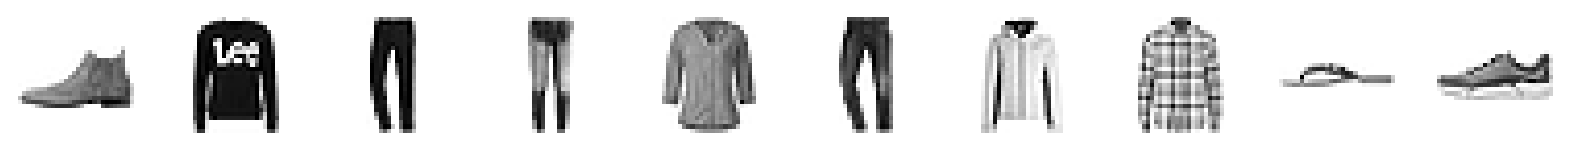

Reconstruction


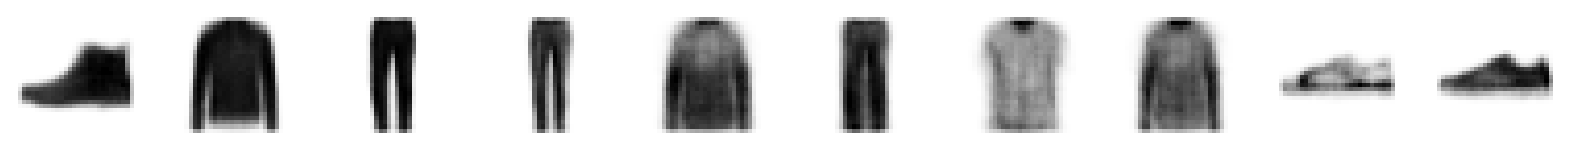

In [20]:
predictions = autoencoder.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstruction")
display(predictions)

### Embed using the encoder 

In [21]:
#Encode the example images 
embeddings = encoder.predict(example_images)

157/157 [==============================] - 0s 517us/step


In [23]:
print(embeddings[:10])

[[ -3.2564821    3.322168  ]
 [  2.371096    -2.68824   ]
 [ -8.909682   -10.037417  ]
 [ -8.551003    -6.6412697 ]
 [  0.22149661  -1.3429047 ]
 [ -4.6677504   -6.360777  ]
 [ -2.050642    -2.128341  ]
 [ -0.201       -1.748585  ]
 [ -6.432038     0.5788288 ]
 [ -6.0325413    2.1258316 ]]


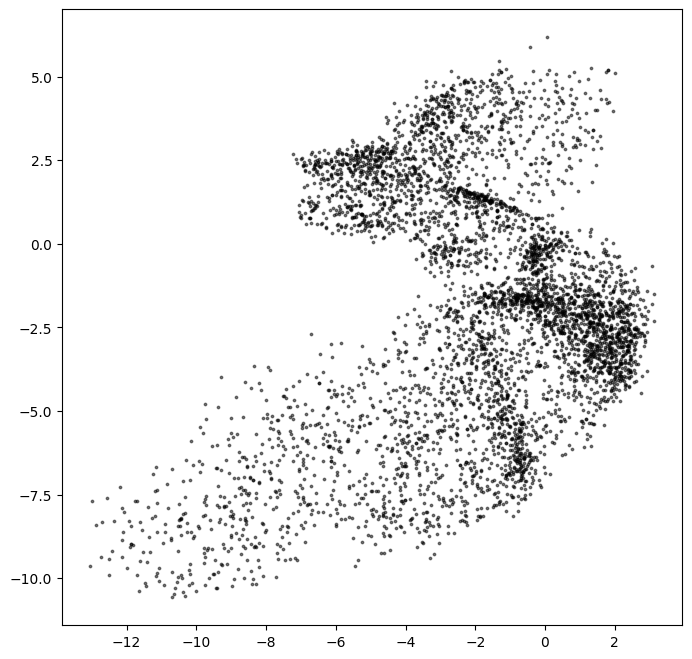

In [24]:
#Show the encoded points in 2D space 
figsize = 8 
plt.figure(figsize=(figsize,figsize))
plt.scatter(embeddings[:,0],embeddings[:,1],c="black",alpha=0.5,s=3)
plt.show()

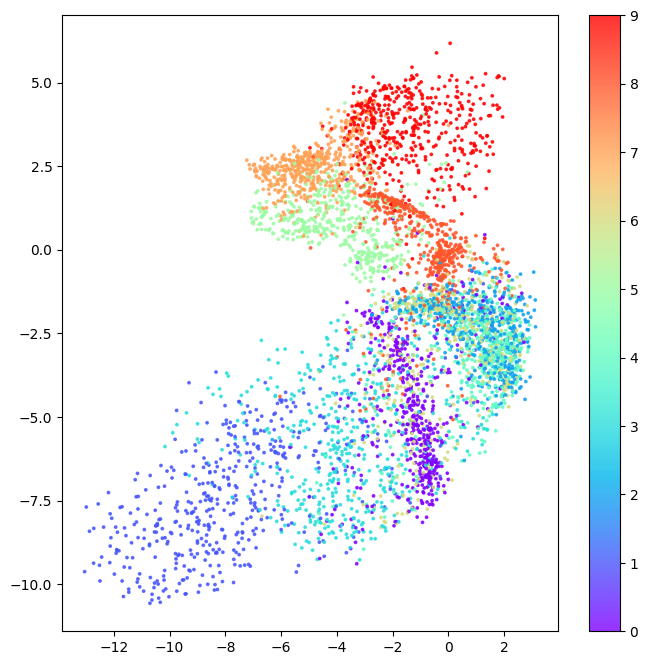

In [25]:
#Color the embeddings by their label 
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize,figsize))
plt.scatter(
    embeddings[:,0],
    embeddings[:,1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,)
plt.colorbar()
plt.show()
    

### Generate using the decoder 


In [26]:
#Get the range of the existing embeddings 
mins,maxs = np.min(embeddings,axis=0), np.max(embeddings,axis=0)

#sample some points in the latent space 
grid_width, grid_height = (6,3)
sample = np.random.uniform(
    mins,maxs,size=(grid_width*grid_height,EMBEDDING_DIM))

In [27]:
#Decode the sample points 
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 70ms/step


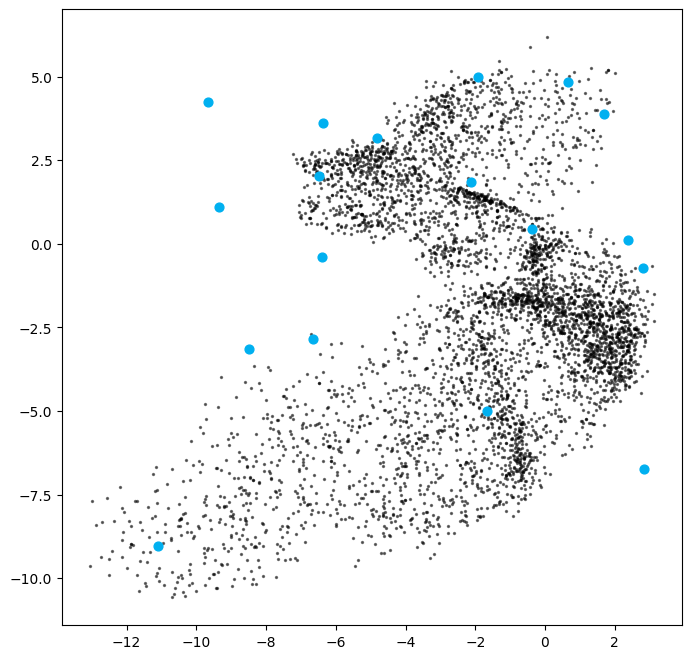

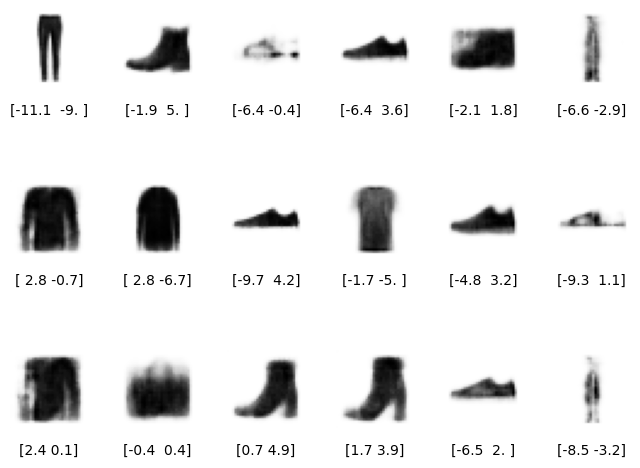

In [28]:
figsize = 8 
plt.figure(figsize = (figsize,figsize))


#... the original embeddings 
plt.scatter(embeddings[:,0],embeddings[:,1],c="black",alpha=0.5,s=2)

#newly generated points in the latent space
plt.scatter(sample[:,0], sample[:,1], c="#00B0F0",alpha=1,s=40)
plt.show() 

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 3ms/step


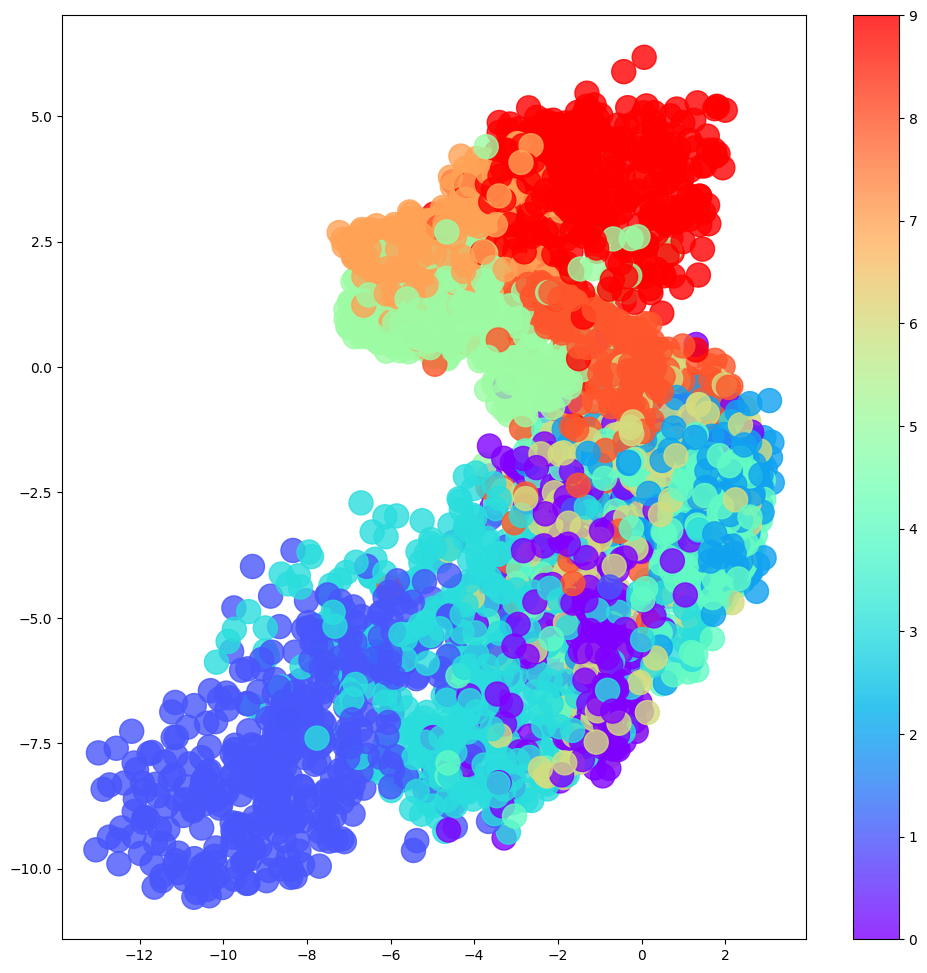

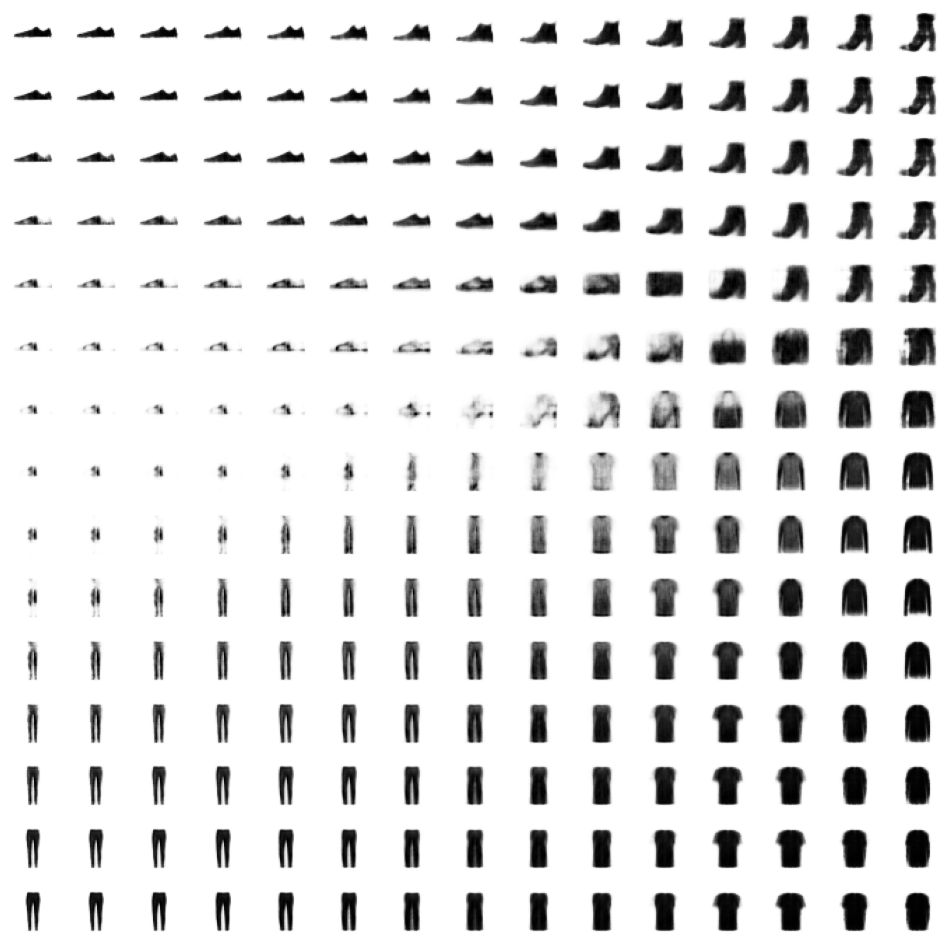

In [29]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

The distribution of the embeddings in the latent space is undefined. At some of the region, the encodings are available and on some of the points, the encodings are empty. So, choosing a random point from these latent space may not always give us desired result.If we are to use more dimensions to generate latent space of complex problems, the problem of empty encodings becomes more prevalent